<a href="https://colab.research.google.com/github/AmandinChyba/Project1-Fields-2022/blob/main/Walk_on_Boundary_and_BIEM/WalkOnBoundary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [239]:
import jax
from jax import lax
from jax import random

import jax.numpy as jnp
import numpy as np

import time

import matplotlib.pyplot as plt

from functools import partial

In [241]:
@jax.jit
def unit_circle_distance(p): # signed distance function for 2d unit circle
  return jnp.linalg.norm(p,ord=2,axis=0) - 1

In [242]:
@jax.jit
def boundaryCond(p):
  return p[1]

In [243]:
@jax.jit
def binaryRootSearch(p0, p1, epochs, dir):
  p1 = p0 + p1 # need to center p1 at p0

  current = jnp.zeros((1, jnp.size(p0, axis=1)))

  def binaryStep(i, current):
    next = current + jnp.power(0.5,i+1)
    dist = unit_circle_distance(p0 + dir * next * (p1 - p0)) # need to specify signed distance function
                                                             # cause its not a JAX-type
    return jnp.where(dist > 0, current, next)
  
  current = lax.fori_loop(0, epochs, binaryStep, current)
  
  return p0 + dir * current * (p1 - p0), current # return the roots, t-values

In [244]:
@jax.jit
def wob(p0, p1, t, epochs):
  runningEst = 0
  runningSign = 1

  pNext, tFirst = binaryRootSearch(p0, p1[0], epochs, 1)

  for p in p1[1:]:
    runningEst += runningSign * boundaryCond(pNext)
    runningSign *= -1 
    pBack, tBack = binaryRootSearch(pNext, p, epochs, -1)
    pFor, tFor = binaryRootSearch(pNext, p, epochs, 1)
    pNext = jnp.where(tBack - tFor > 0, pBack, pFor)

  runningEst *= 2
  runningEst += runningSign * boundaryCond(pNext)
  return runningEst

In [245]:
def computeSoln(t, epochs, batches, p, key):
  p0 = jnp.full((len(p), batches),p)

  # generate random directions in n-dimensions
  diameter = 2
  p1 = random.normal(key, shape=(t, len(p), batches))
  normalize = jnp.linalg.norm(p1, ord=2, axis=1).reshape((t, 1, batches))
  p1 = diameter * jnp.divide(p1, normalize)

  ans = wob(p0, p1, t, epochs)
  return jnp.mean(ans)

In [268]:
%%time
key = random.PRNGKey(int(time.time()))
x = jnp.array([[0.3,0.8]]).transpose()
print(computeSoln(2, 15, 100000, x, key))

0.7979811
CPU times: user 35 ms, sys: 1.85 ms, total: 36.8 ms
Wall time: 37.5 ms


CPU times: user 334 ms, sys: 22.1 ms, total: 356 ms
Wall time: 275 ms


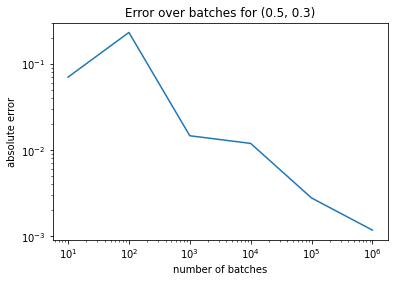

In [272]:
%%time
t = 2 # number of jumps on the boundary
epochs = 10 # binary search time steps
batches = np.power(10,np.arange(1,7))
x = jnp.array([[0.5,0.3]]).transpose()

key = random.PRNGKey(int(time.time()))
keys = random.split(key, len(batches))

values = np.zeros(len(batches))
for i in range(len(batches)):
  values[i] = computeSoln(t, epochs, batches[i], x, keys[i])

error = np.abs(values - 0.3)
plt.plot(batches, error)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of batches')
plt.ylabel('absolute error')
plt.title('Error over batches for (0.5, 0.3)')